## Required Packages

In [16]:
import os
import numpy as np
import torch
from torch import nn,optim,functional
import torch.nn.functional as F

from torchvision import models,transforms,datasets
from torchsummary import summary
from torch.utils.data import WeightedRandomSampler, random_split,Dataset,DataLoader,Subset,ConcatDataset

from torchvision.datasets.folder import default_loader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import SequentialLR, LinearLR,CosineAnnealingLR

from torchvision.transforms import v2

import random
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter,defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,confusion_matrix, classification_report, ConfusionMatrixDisplay

import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## File Paths

In [ ]:
DATA_DIR = '/kaggle/input/cassava-disease-classification'

TRAIN_DIR = os.path.join(DATA_DIR, "train/train")
Exra_DIR = os.path.join(DATA_DIR, "extraimages/extraimages")
TEST_DIR = os.path.join(DATA_DIR, "test/test/0")

## Data Distribution

Image counts per class:
cmd: 2658
cbb: 466
cbsd: 1443
healthy: 316
cgm: 773
Total images: 5656


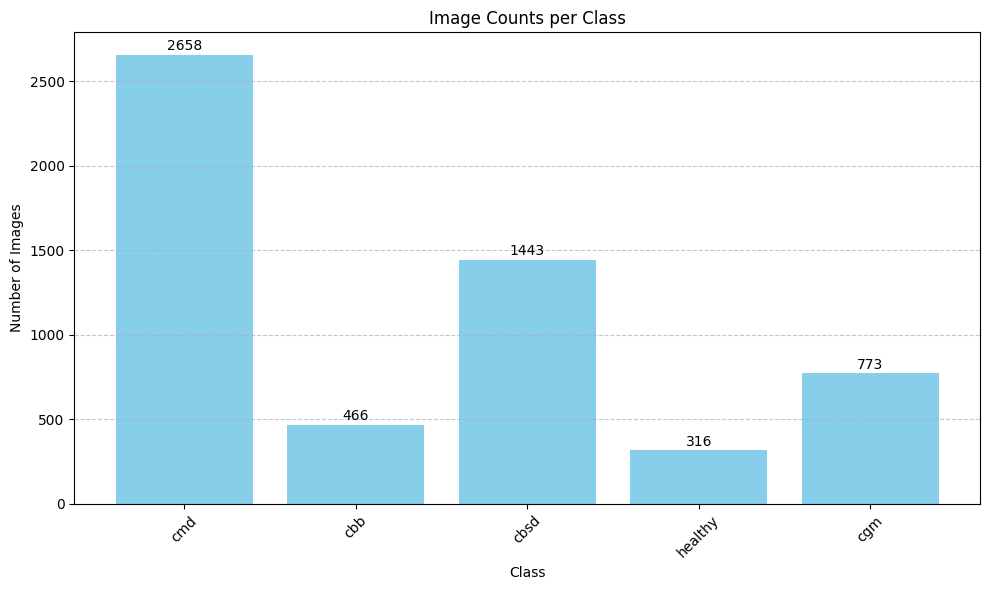

In [18]:
class_counts = Counter()
for root, dirs, files in os.walk(TRAIN_DIR):
    for d in dirs:
        class_path = os.path.join(root, d)
        count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
        class_counts[d] = count

print("Image counts per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print("Total images:", sum(class_counts.values()))


classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10,6))
bars = plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Counts per Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Plot Examples From Each Class

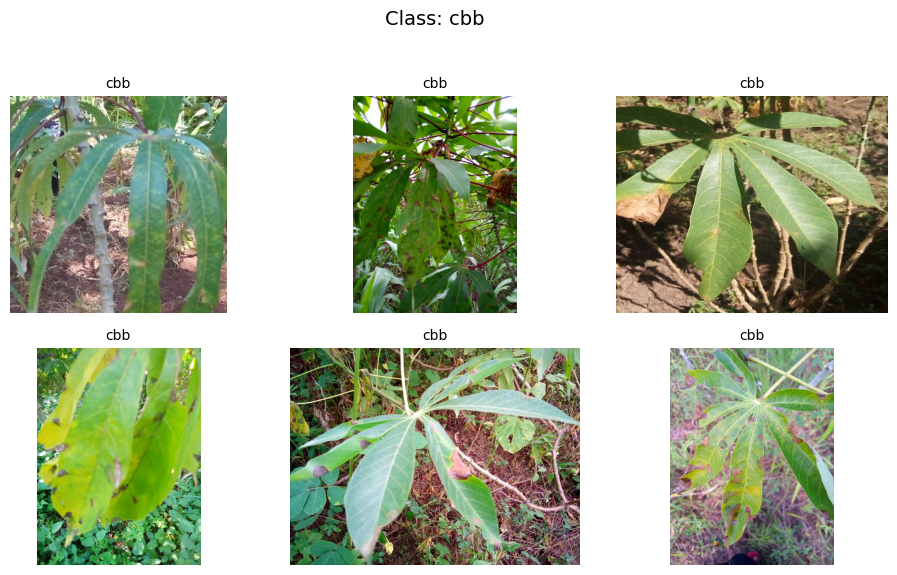

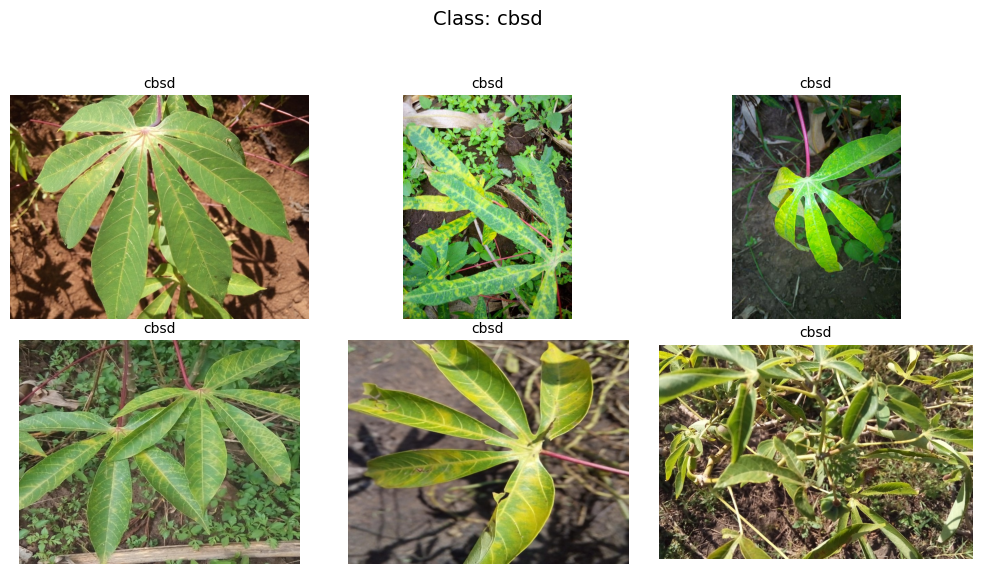

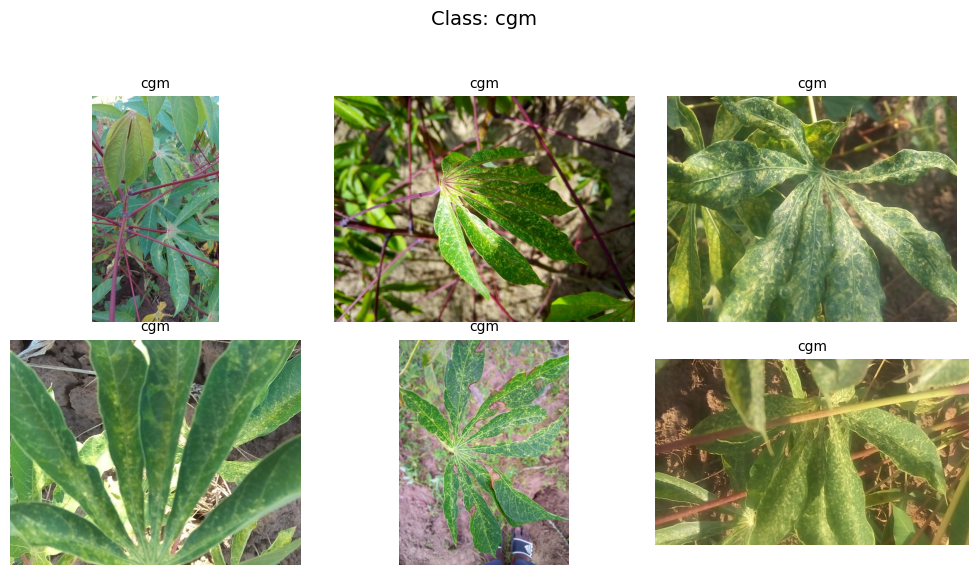

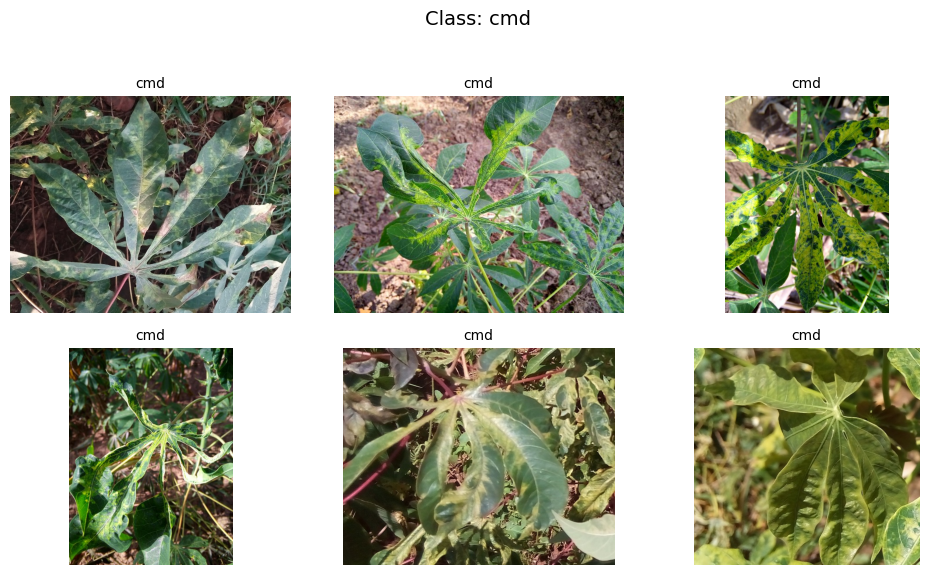

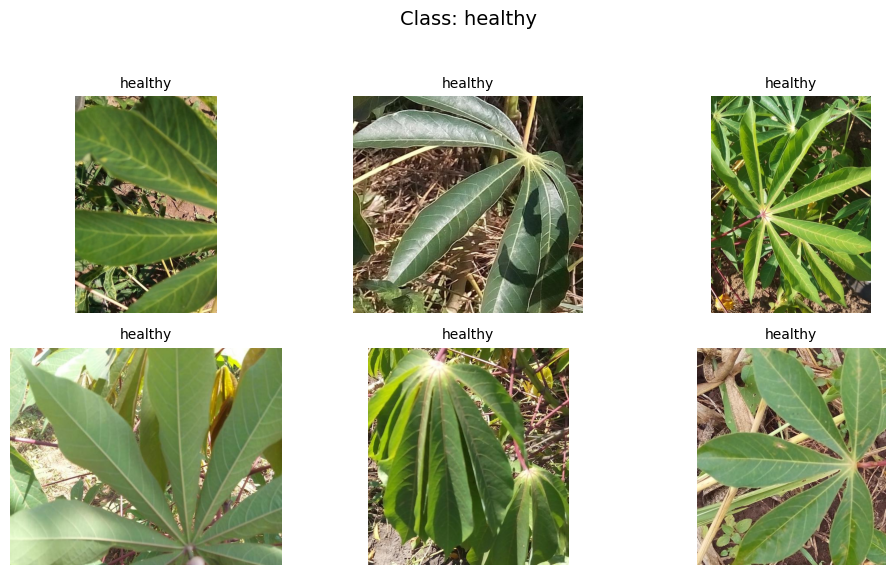

In [19]:
def plot_images_per_class(data_dir, num_images=6):
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        
        if len(images) < num_images:
            print(f"Class '{class_name}' has only {len(images)} images, expected at least {num_images}.")
            continue

        selected_images = random.sample(images, num_images)

        plt.figure(figsize=(10, 6))  # Adjust size as needed
        for i, image_file in enumerate(selected_images):
            img_path = os.path.join(class_path, image_file)
            image = Image.open(img_path).convert('RGB')
            plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
            plt.imshow(image)
            plt.title(f"{class_name}", fontsize=10)
            plt.axis('off')

        plt.suptitle(f"Class: {class_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_images_per_class(TRAIN_DIR, num_images=6)

## Data Augmentation and Validation Split

In [33]:
## Data Augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
### TRAIN Augmentation ###
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(380), #380#299#224
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
### TEST Augmentation ###
test_val_transforms = transforms.Compose([
    transforms.Resize(400),#400#310#256
    transforms.CenterCrop(380),#380#299#224
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### Split Training(80%), Validation(10%) and Test (10%) ###
full_dataset = datasets.ImageFolder(TRAIN_DIR)
targets = full_dataset.targets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_test_idx in splitter.split(full_dataset.samples, targets):
    val_size = len(val_test_idx) // 2
    val_idx = val_test_idx[:val_size]
    test_idx = val_test_idx[val_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
valid_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.loader = default_loader

    def __getitem__(self, idx):
        path, _ = self.subset.dataset.samples[self.subset.indices[idx]]
        label = self.subset.dataset.targets[self.subset.indices[idx]]
        image = self.loader(path)
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)


train_dataset = TransformedSubset(train_dataset, train_transforms)
valid_dataset = TransformedSubset(valid_dataset, test_val_transforms)
test_dataset = TransformedSubset(test_dataset, test_val_transforms)

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

submit_test_dataset = TestDataset(TEST_DIR, transform=test_val_transforms)
extra_dataset = TestDataset(Exra_DIR, transform=test_val_transforms)

## Training, Validation and Test, Data Distribution

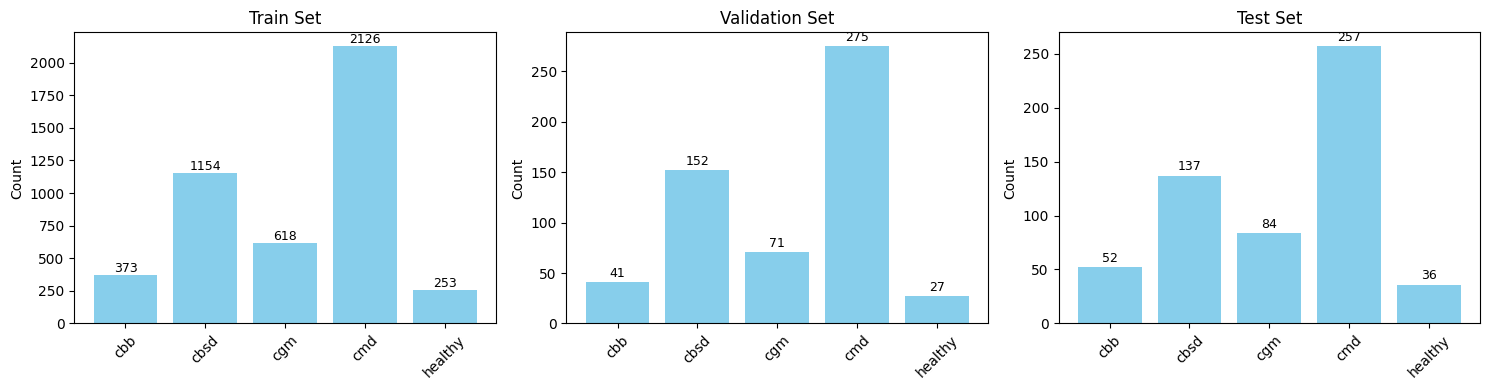

In [21]:
def get_labels(dataset):
    """
    Supports:
    - TransformedSubset (has .subset.indices and .subset.dataset.targets/labels)
    - Subset (has .indices and .dataset.targets/labels)
    - PseudoLabeledDataset or similar (has .labels)
    - Datasets with .targets
    - ConcatDataset (combines labels of all datasets)
    """
    if isinstance(dataset, ConcatDataset):
        labels = []
        for ds in dataset.datasets:
            labels.extend(get_labels(ds))
        return labels

    if hasattr(dataset, 'subset'):  # TransformedSubset
        indices = dataset.subset.indices
        base_dataset = dataset.subset.dataset
        if hasattr(base_dataset, 'targets'):
            targets = base_dataset.targets
            return [targets[i] for i in indices]
        elif hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
            return [labels[i] for i in indices]
    
    if hasattr(dataset, 'indices') and hasattr(dataset, 'dataset'):  # Subset
        indices = dataset.indices
        base_dataset = dataset.dataset
        if hasattr(base_dataset, 'targets'):
            targets = base_dataset.targets
            return [targets[i] for i in indices]
        elif hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
            return [labels[i] for i in indices]
    
    if hasattr(dataset, 'labels'):
        return dataset.labels
    if hasattr(dataset, 'targets'):
        return dataset.targets

    raise ValueError("Dataset does not have labels or targets attribute.")

def plot_class_distribution(datasets, dataset_names, class_names):
    plt.figure(figsize=(15, 4))

    for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
        labels = get_labels(dataset)
        counts = Counter(labels)
        sorted_counts = [counts[i] for i in range(len(class_names))]

        plt.subplot(1, len(datasets), i + 1)
        bars = plt.bar(class_names, sorted_counts, color='skyblue')
        plt.title(f"{name} Set")
        plt.xticks(rotation=45)
        plt.ylabel("Count")

        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 2,
                str(height),
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.tight_layout()
    plt.show()
class_names = full_dataset.classes
plot_class_distribution(
    datasets=[train_dataset, valid_dataset, test_dataset],
    dataset_names=["Train", "Validation", "Test"],
    class_names=class_names
)


## Weighted Class and Weighted Random Sampler

In [22]:
# Count labels in the train dataset
all_train_labels = [train_dataset.subset.dataset.targets[i] for i in train_dataset.subset.indices]
class_counts = Counter(all_train_labels)
num_classes = len(class_counts)

# Compute weights
total_samples = sum(class_counts.values())
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Recalculate targets from train_dataset
train_targets = [train_dataset.subset.dataset.targets[i] for i in train_dataset.subset.indices]
class_sample_counts = np.array([class_counts[i] for i in range(num_classes)])
weights = 1. / class_sample_counts
sample_weights = np.array([weights[label] for label in train_targets])
sample_weights = torch.from_numpy(sample_weights).float()

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

## Create DataLoader

In [35]:
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #sampler=sampler,
    num_workers=2,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

extra_loader = DataLoader(
    extra_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

submit_test_loader = DataLoader(
    submit_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Number of classes    : ", len(full_dataset.classes))
print("No. of train images  : ", len(train_dataset))
print("No. of valid images  : ", len(valid_dataset))
print("No. of test images  : ", len(test_dataset))
print("No. of test images (submit)  : ", len(submit_test_dataset))
print("No. of extra images  : ", len(extra_dataset))
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", batch_size)
print("Train batches        : ", len(train_loader))
print("Val batches          : ", len(valid_loader))

Number of classes    :  5
No. of train images  :  4524
No. of valid images  :  566
No. of test images  :  566
No. of test images (submit)  :  3774
No. of extra images  :  12595
Shape of image       :  torch.Size([3, 380, 380])
Batch size           :  8
Train batches        :  566
Val batches          :  71


## Plot Some Training Images With Training Transformation

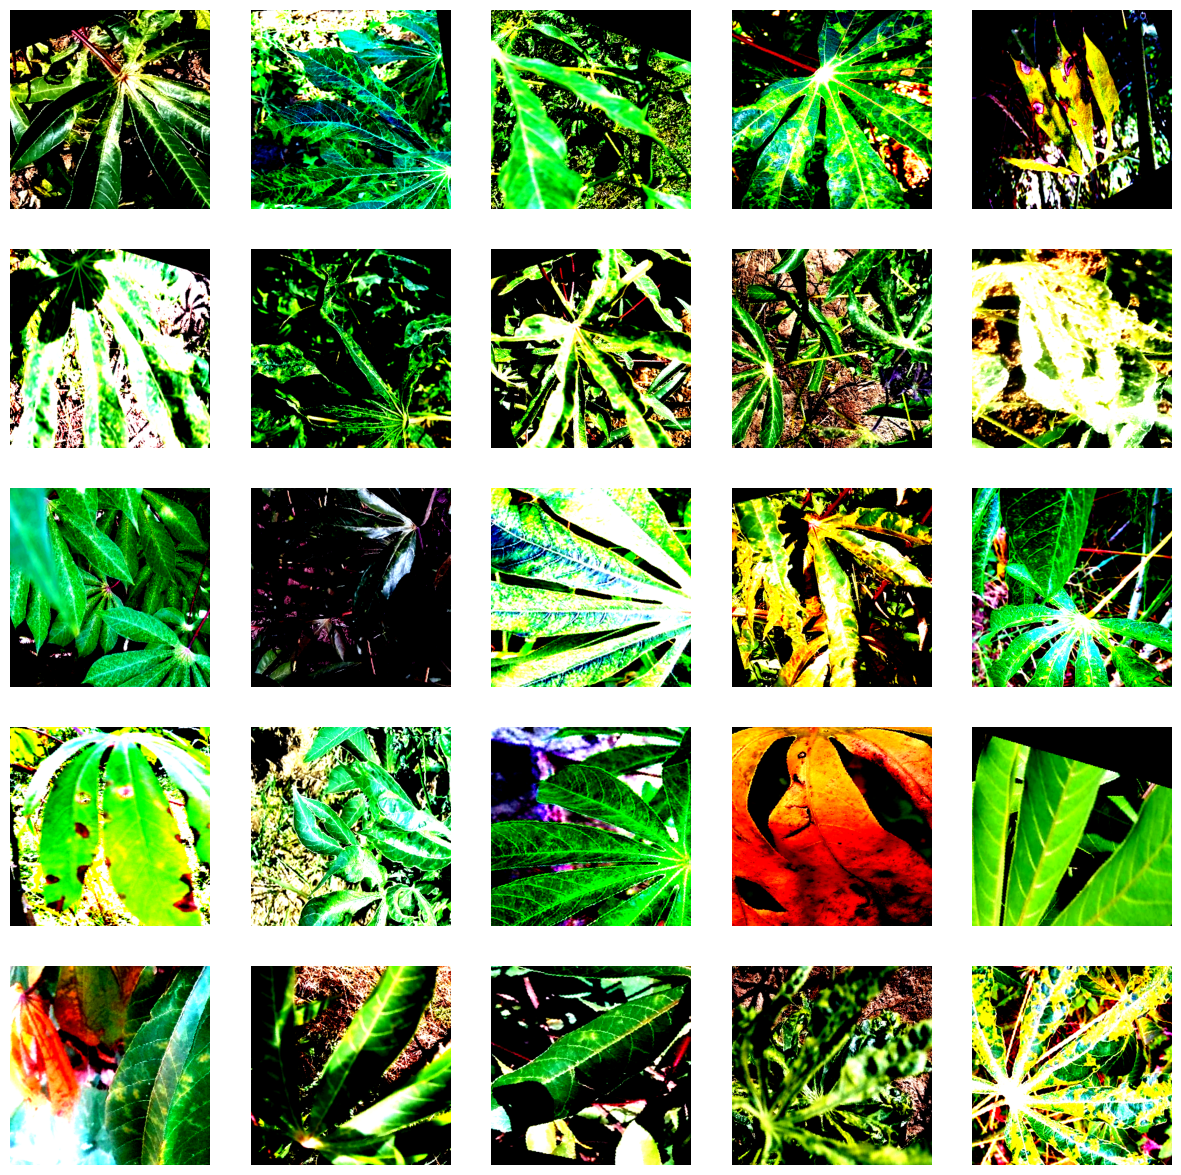

In [24]:
r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = datasets.ImageFolder(TRAIN_DIR, transform= train_transforms),
    batch_size  = 32,
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

## Plotting The Loss and Accuracy

In [36]:
def plot_loss_accuracy(train_losses, test_losses, train_accs, test_accs, title=""):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Vs Epochs {title}')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Vs Epochs {title}')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_all_accuracies(histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in histories.items():
        plt.plot(history['train_acc'], label=model_name)
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracies(histories):
    for model_name, history in histories.items():
        plot_loss_accuracy(history['train_loss'], history['val_loss'],history['train_acc'], history['val_acc'], title="Model")

## Used To Clear GPU

In [38]:
import gc

#del model

gc.collect()
torch.cuda.empty_cache()

## Model Training

In [39]:
def train_model(
    model,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int = 20,
    scheduler=None,
    scheduler_on='val_loss',
    plot_fn=None,
    plot_title="Training Progress",
    use_mixup=False,
    early_stopping=False,
    patience=3
):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies, val_f1_scores = [], [], []

    model.to(device)

    best_f1 = 0
    wait = 0
    best_model_wts = None
    val_criterion = nn.CrossEntropyLoss()

    if use_mixup:
        cutmix = v2.CutMix(num_classes=5)
        mixup = v2.MixUp(num_classes=5)
        cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
    else:
        cutmix_or_mixup = None

    for epoch in range(num_epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            if use_mixup and cutmix_or_mixup:
                images, labels = cutmix_or_mixup(images, labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(labels, dim=1) if labels.ndim == 2 else labels
            correct_train += (predicted == true_labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                running_val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                true_labels = torch.argmax(labels, dim=1) if labels.ndim == 2 else labels

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(true_labels.cpu().numpy())

                correct_val += (predicted == true_labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(valid_loader)
        val_accuracy = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        if scheduler:
            if scheduler_on == 'val_loss':
                scheduler.step(avg_val_loss)
            elif scheduler_on == 'epoch':
                scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"LR: {current_lr:.6f} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
              f"Val F1: {val_f1:.4f}")

        # -------- EARLY STOPPING (on F1) ----------
        if early_stopping:
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_wts = model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    if plot_fn:
        plot_fn(train_losses, val_losses, train_accuracies, val_accuracies, title=plot_title)

    return model, {
        "train_loss": train_losses,
        "train_acc": train_accuracies,
        "val_loss": val_losses,
        "val_acc": val_accuracies,
        "val_f1": val_f1_scores
    }


## Evaluate Model

In [40]:
def evaluate(model, dataloader, criterion, device, class_names=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    eval_criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # loss = criterion(outputs, labels)
            loss = eval_criterion(outputs, labels)
            
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)

            preds = torch.argmax(outputs, dim=1)
            if labels.ndim == 2:  # for soft labels
                labels = torch.argmax(labels, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}")
    
    # ----- Confusion Matrix -----
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ----- Classification Report -----
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return avg_loss, accuracy

## FocalLoss

In [42]:
class FocalLossMultiClass(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLossMultiClass, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Soft targets (MixUp, CutMix)
        if targets.ndim == 2 and targets.size(1) == inputs.size(1):
            pt = (probs * targets).sum(dim=1)
            log_pt = (log_probs * targets).sum(dim=1)

            if self.alpha is not None:
                if isinstance(self.alpha, (list, torch.Tensor)):
                    alpha = torch.tensor(self.alpha).to(inputs.device)
                    alpha_t = (alpha * targets).sum(dim=1)
                else:
                    alpha_t = self.alpha
                log_pt = alpha_t * log_pt

        else:
            # Hard labels
            targets = targets.view(-1, 1)
            log_pt = log_probs.gather(1, targets).squeeze(1)
            pt = probs.gather(1, targets).squeeze(1)

            if self.alpha is not None:
                if isinstance(self.alpha, (list, torch.Tensor)):
                    alpha = torch.tensor(self.alpha).to(inputs.device)
                    alpha_t = alpha[targets.squeeze()]
                else:
                    alpha_t = self.alpha
                log_pt = alpha_t * log_pt

        loss = -1 * (1 - pt) ** self.gamma * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

## Training The Model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the 


 Training DenseNet121...

Epoch [1/15] | LR: 0.000099 | Train Loss: 0.9605, Train Acc: 0.7210 | Val Loss: 0.4321, Val Acc: 0.8710 | Val F1: 0.7970
Epoch [2/15] | LR: 0.000096 | Train Loss: 0.8343, Train Acc: 0.7940 | Val Loss: 0.4016, Val Acc: 0.8852 | Val F1: 0.8281
Epoch [3/15] | LR: 0.000090 | Train Loss: 0.7934, Train Acc: 0.8172 | Val Loss: 0.3938, Val Acc: 0.8887 | Val F1: 0.8349
Epoch [4/15] | LR: 0.000083 | Train Loss: 0.7696, Train Acc: 0.8298 | Val Loss: 0.3863, Val Acc: 0.9011 | Val F1: 0.8545
Epoch [5/15] | LR: 0.000075 | Train Loss: 0.7355, Train Acc: 0.8490 | Val Loss: 0.3900, Val Acc: 0.8922 | Val F1: 0.8446
Epoch [6/15] | LR: 0.000065 | Train Loss: 0.7294, Train Acc: 0.8512 | Val Loss: 0.3921, Val Acc: 0.8922 | Val F1: 0.8190
Epoch [7/15] | LR: 0.000055 | Train Loss: 0.7082, Train Acc: 0.8548 | Val Loss: 0.4036, Val Acc: 0.8905 | Val F1: 0.8269
Epoch [8/15] | LR: 0.000045 | Train Loss: 0.6982, Train Acc: 0.8610 | Val Loss: 0.3845, Val Acc: 0.8869 | Val F1: 0.8301
Epoch

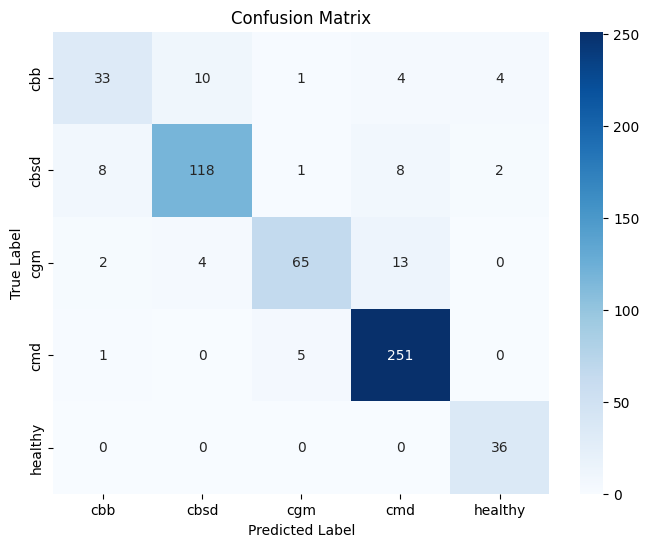


Classification Report:
              precision    recall  f1-score   support

         cbb       0.75      0.63      0.69        52
        cbsd       0.89      0.86      0.88       137
         cgm       0.90      0.77      0.83        84
         cmd       0.91      0.98      0.94       257
     healthy       0.86      1.00      0.92        36

    accuracy                           0.89       566
   macro avg       0.86      0.85      0.85       566
weighted avg       0.89      0.89      0.89       566

Test Loss: 0.3551, Accuracy: 88.87%

 Training EfficientNet-B4...

Epoch [1/10] | LR: 0.000976 | Train Loss: 0.9329, Train Acc: 0.7407 | Val Loss: 0.4771, Val Acc: 0.8869 | Val F1: 0.8185
Epoch [2/10] | LR: 0.000905 | Train Loss: 0.8042, Train Acc: 0.8099 | Val Loss: 0.4204, Val Acc: 0.8763 | Val F1: 0.7878
Epoch [3/10] | LR: 0.000794 | Train Loss: 0.7575, Train Acc: 0.8344 | Val Loss: 0.3926, Val Acc: 0.8958 | Val F1: 0.8448
Epoch [4/10] | LR: 0.000655 | Train Loss: 0.7212, Train A

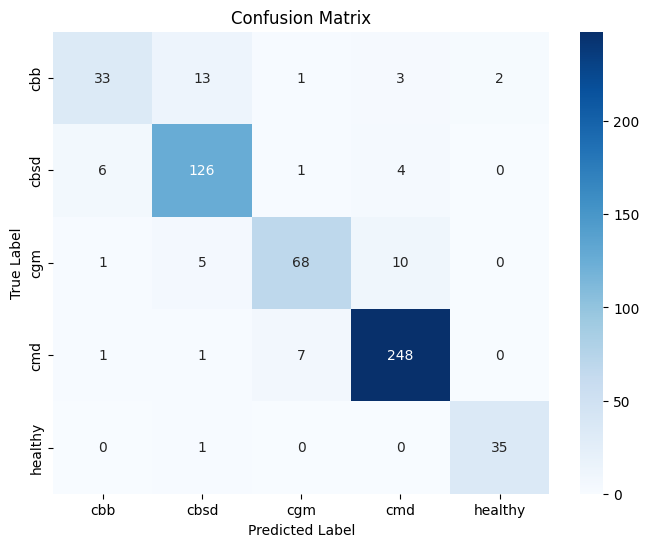


Classification Report:
              precision    recall  f1-score   support

         cbb       0.80      0.63      0.71        52
        cbsd       0.86      0.92      0.89       137
         cgm       0.88      0.81      0.84        84
         cmd       0.94      0.96      0.95       257
     healthy       0.95      0.97      0.96        36

    accuracy                           0.90       566
   macro avg       0.89      0.86      0.87       566
weighted avg       0.90      0.90      0.90       566

Test Loss: 0.3496, Accuracy: 90.11%

 Training ConvNeXt...

Epoch [1/10] | LR: 0.000098 | Train Loss: 0.8659, Train Acc: 0.7670 | Val Loss: 0.4597, Val Acc: 0.8693 | Val F1: 0.7835
Epoch [2/10] | LR: 0.000090 | Train Loss: 0.7083, Train Acc: 0.8492 | Val Loss: 0.3975, Val Acc: 0.8781 | Val F1: 0.8269
Epoch [3/10] | LR: 0.000079 | Train Loss: 0.6679, Train Acc: 0.8747 | Val Loss: 0.3817, Val Acc: 0.8975 | Val F1: 0.8419
Epoch [4/10] | LR: 0.000065 | Train Loss: 0.6379, Train Acc: 0.8

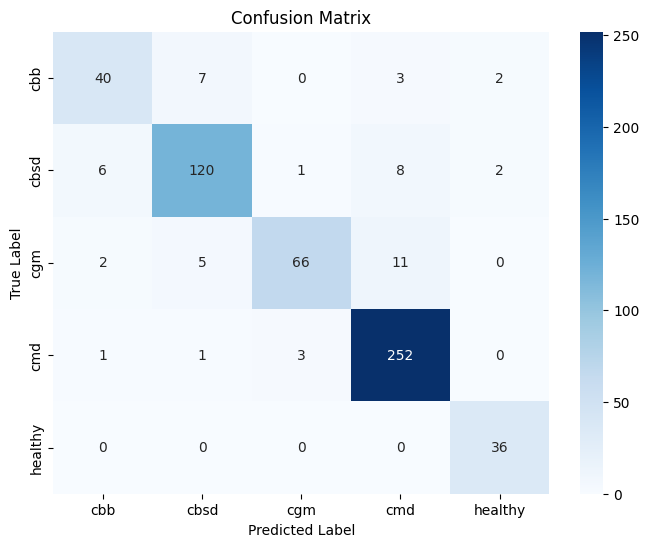


Classification Report:
              precision    recall  f1-score   support

         cbb       0.82      0.77      0.79        52
        cbsd       0.90      0.88      0.89       137
         cgm       0.94      0.79      0.86        84
         cmd       0.92      0.98      0.95       257
     healthy       0.90      1.00      0.95        36

    accuracy                           0.91       566
   macro avg       0.90      0.88      0.89       566
weighted avg       0.91      0.91      0.91       566

Test Loss: 0.3425, Accuracy: 90.81%


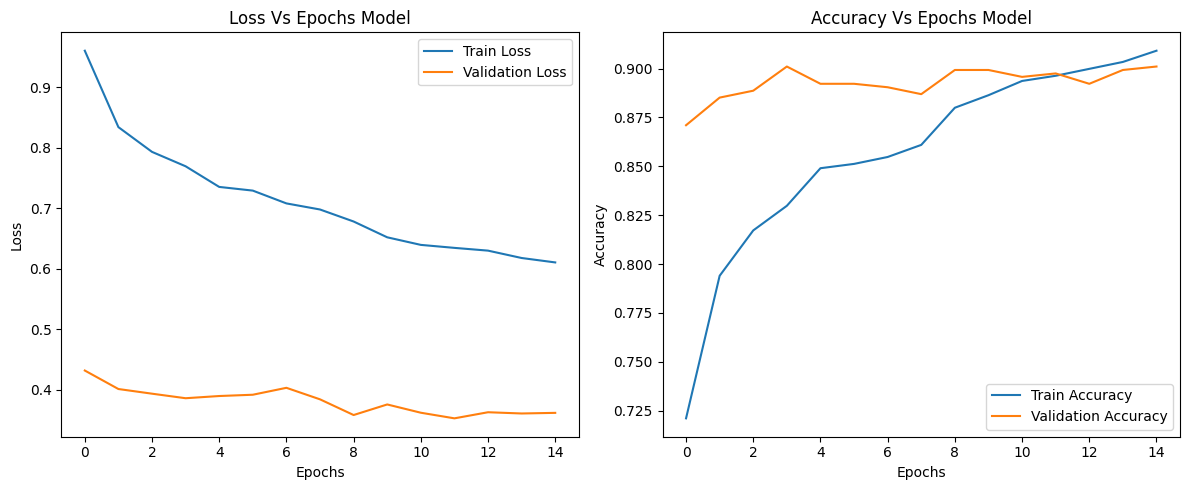

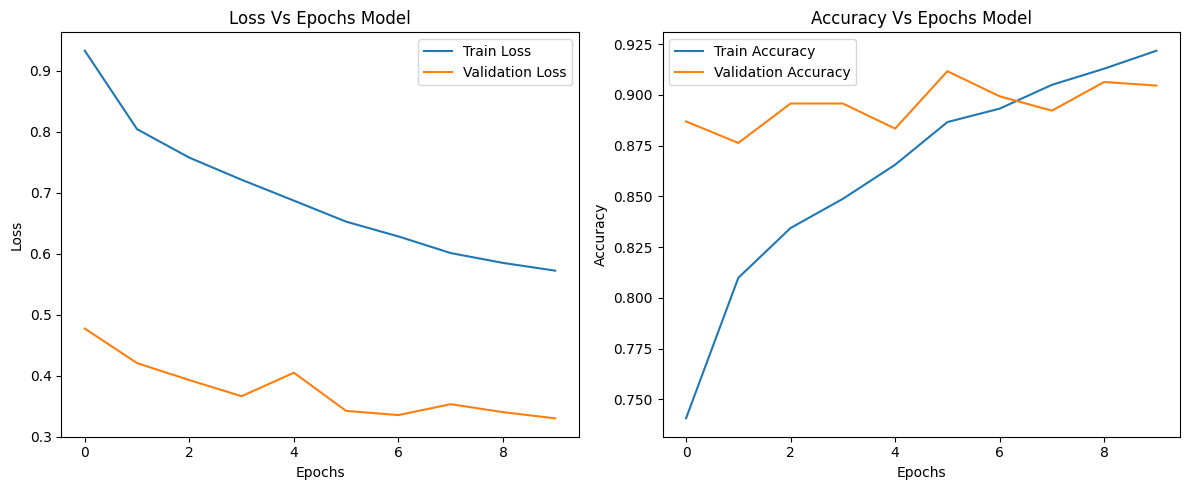

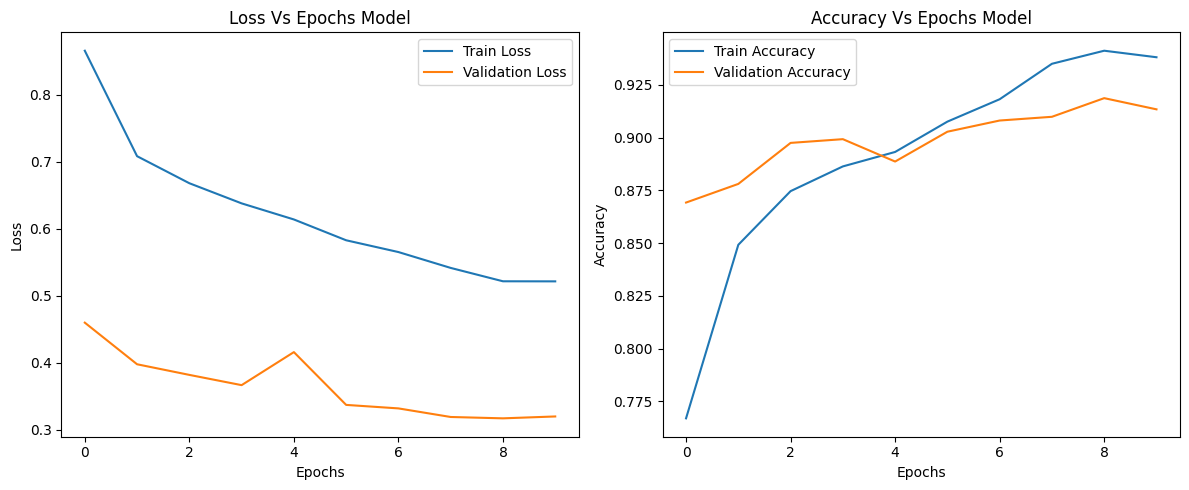

In [43]:
num_classes = 5

model_dict = {
    "DenseNet121": models.densenet121(pretrained=True),
    "EfficientNet-B4": models.efficientnet_b4(pretrained=True),
    #"ResNet50": models.resnet50(pretrained=True),
    "ConvNeXt": models.convnext_tiny(pretrained=True),
    #"ResNet101": models.resnet101(pretrained=True),
     #"MobileNetV2": models.mobilenet_v2(pretrained=True)
}

model_dict["EfficientNet-B4"].classifier[1] = nn.Linear(model_dict["EfficientNet-B4"].classifier[1].in_features, num_classes)
#model_dict["ResNet50"].fc = nn.Linear(model_dict["ResNet50"].fc.in_features, num_classes)
model_dict["ConvNeXt"].classifier[-1]  = nn.Linear(model_dict["ConvNeXt"].classifier[-1].in_features, num_classes)

#model_dict["ResNet101"].fc = nn.Linear(model_dict["ResNet101"].fc.in_features, num_classes)
model_dict["DenseNet121"].classifier = nn.Linear(model_dict["DenseNet121"].classifier.in_features, num_classes)
#model_dict["MobileNetV2"].classifier[1] = nn.Linear(model_dict["MobileNetV2"].classifier[1].in_features, num_classes)


histories = {}

os.makedirs("saved_models", exist_ok=True)

for model_name, model in model_dict.items():
    print(f"\n Training {model_name}...\n")
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    #criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    #criterion = FocalLossMultiClass(alpha=class_weights_tensor.cpu().tolist(), gamma=gamma, reduction='mean')
    #criterion = FocalLossMultiClass(gamma=2.0, reduction='mean')

    #optimizer = optim.Adam(model.parameters(), lr=0.0001) #0.0001
    #optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
    if model_name == "EfficientNet-B4":
        epochs = 10
        optimizer = optim.AdamW(model.parameters(), lr=0.001) #0.001
    elif model_name == "ConvNeXt":
        epochs = 10
        optimizer = optim.AdamW(model.parameters(), lr=0.0001) #0.00001
    else:
        epochs = 15
        optimizer = optim.AdamW(model.parameters(), lr=0.0001) #0.0001
        
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    # warmup_epochs = 2
    # total_epochs = 10
    # main_epochs = total_epochs - warmup_epochs

    # warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs)
    # cosine_scheduler = CosineAnnealingLR(optimizer, T_max=main_epochs)

    # scheduler = SequentialLR(
    #     optimizer,
    #     schedulers=[warmup_scheduler, cosine_scheduler],
    #     milestones=[warmup_epochs]
    # )
    
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader, #train_loader #new_train_loader #reduced_new_train_loader
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler, 
        scheduler_on='epoch', #epoch, val_loss
        device=device,
        num_epochs=epochs,
        plot_fn=None,
        early_stopping=False,
        use_mixup=False
    )

    save_path = f"saved_models/{model_name.replace(' ', '_')}.pth"
    torch.save(trained_model.state_dict(), save_path)
    print(f" Saved {model_name} to: {save_path}")

    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device, full_dataset.classes)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")

    histories[model_name] = history
#plot_all_accuracies(histories)
plot_accuracies(histories)

## Load Saved Model

In [44]:
num_classes = 5 
####---Model 1: EfficientNet-B4---###
model_1 = models.efficientnet_b4(None)
model_1.classifier[1] = nn.Linear(model_1.classifier[1].in_features, num_classes)
model_1 = model_1.to(device)
weights_path_1 = "/kaggle/working/saved_models/EfficientNet-B4.pth"
model_1.load_state_dict(torch.load(weights_path_1, map_location=device))
model_1.eval()

####---Model 2: ConvNeXt---###
model_2 =models.convnext_tiny(pretrained=True)
model_2.classifier[-1]  = nn.Linear(model_2.classifier[-1].in_features, num_classes)
model_2 = model_2.to(device)
weights_path_2 = "/kaggle/working/saved_models/ConvNeXt.pth"
model_2.load_state_dict(torch.load(weights_path_2, map_location=device))
model_2.eval()

####---Model 3: DenseNet121---###
model_3 = models.densenet121(pretrained=True)
model_3.classifier = nn.Linear(model_3.classifier.in_features, num_classes)
model_3 = model_3.to(device)
weights_path_3 = "/kaggle/working/saved_models/DenseNet121.pth"
model_3.load_state_dict(torch.load(weights_path_3, map_location=device))
model_3.eval()

print("Ready To use")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enu

Ready To use


## Evaluation Of Ensebled Models

Ensemble Loss: 0.5991, Accuracy: 90.46%


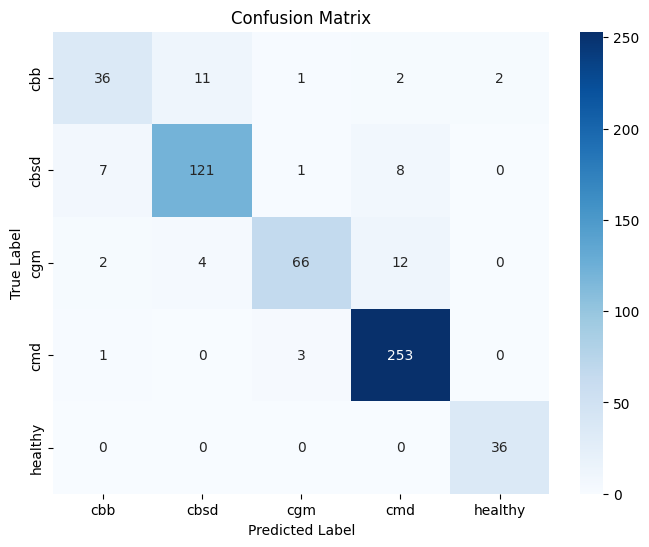


Classification Report:
              precision    recall  f1-score   support

         cbb       0.78      0.69      0.73        52
        cbsd       0.89      0.88      0.89       137
         cgm       0.93      0.79      0.85        84
         cmd       0.92      0.98      0.95       257
     healthy       0.95      1.00      0.97        36

    accuracy                           0.90       566
   macro avg       0.89      0.87      0.88       566
weighted avg       0.90      0.90      0.90       566

Ensemble Test Loss: 0.5991, Accuracy: 90.46%


In [45]:
def evaluate_ensemble(model1, model2, model3, dataloader, criterion, device, class_names=None):
    model1.eval()
    model2.eval()
    model3.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Get outputs from all models
            outputs1 = model1(images)
            outputs2 = model2(images)
            outputs3 = model3(images)

            # Average the softmax probabilities
            probs1 = F.softmax(outputs1, dim=1)
            probs2 = F.softmax(outputs2, dim=1)
            probs3 = F.softmax(outputs3, dim=1)
            avg_probs = (probs1 + probs2 + probs3) / 3

            # Handle soft labels
            if labels.ndim == 2:
                labels = torch.argmax(labels, dim=1)

            # Compute loss using log probabilities
            loss = criterion(avg_probs.log(), labels)

            total_loss += loss.item()
            preds = torch.argmax(avg_probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    print(f"Ensemble Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return avg_loss, accuracy
test_loss, test_accuracy = evaluate_ensemble(model_1, model_2, model_3, test_loader, criterion, device, full_dataset.classes)

print(f"Ensemble Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")


## Label The Extra Images Using The Trained Models

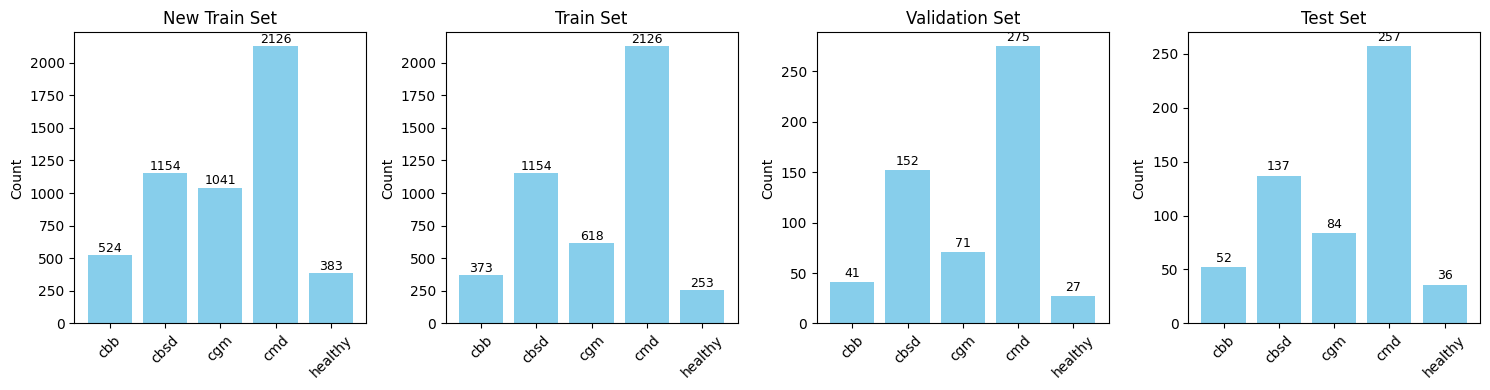

In [30]:
pseudo_labels = []
image_paths = []

model_1.eval()
model_2.eval()
model_3.eval()

with torch.no_grad():
    for inputs, paths in extra_loader:
        inputs = inputs.to(device)

        # Get logits from each model
        outputs1 = model_1(inputs)
        outputs2 = model_2(inputs)
        outputs3 = model_3(inputs)

        # Compute softmax probabilities
        probs1 = F.softmax(outputs1, dim=1)
        probs2 = F.softmax(outputs2, dim=1)
        probs3 = F.softmax(outputs3, dim=1)

        # Average the probabilities
        avg_probs = (probs1 + probs2 + probs3) / 3

        # Get max prob and corresponding class
        max_probs, preds = torch.max(avg_probs, dim=1)

        for i in range(len(preds)):
            if preds[i].item() in [0,2,4]: # ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
                if max_probs[i].item() >= 0.8:
                    pseudo_labels.append(preds[i].item())
                    image_paths.append(paths[i])

class PseudoLabeledDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

pseudo_dataset = PseudoLabeledDataset(image_paths, pseudo_labels, transform=train_transforms)

train_datas = torch.utils.data.Subset(full_dataset, train_idx)
final_dataset = ConcatDataset([train_dataset, pseudo_dataset])

# Plot New Training Dataset Distribution¶
all_indices = list(range(len(final_dataset)))
final_dataset_subset = Subset(final_dataset, all_indices)
new_train_dataset = TransformedSubset(final_dataset_subset, train_transforms)

plot_class_distribution(
    datasets=[final_dataset,train_dataset, valid_dataset, test_dataset],
    dataset_names=["New Train","Train", "Validation", "Test"],
    class_names=class_names
)

new_train_loader = DataLoader(
    final_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

## Model Evaluation

In [ ]:
class_names = full_dataset.classes
val_loss, val_accuracy = evaluate(model_1, test_loader, criterion, device, class_names)

## Make Model Prediction

In [65]:
### Prediction From Single Model
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs in dataloader:
            if isinstance(inputs, (list, tuple)):
                inputs = inputs[0]  # if dataloader returns (input, label) even for test set
            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds
    
### Prediction From Ensembled Model
def get_ensemble_predictions(model1, model2, model3, dataloader, device):
    model1.eval()
    model2.eval()
    model3.eval()
    all_preds = []

    with torch.no_grad():
        for inputs in dataloader:
            if isinstance(inputs, (list, tuple)):
                inputs = inputs[0]
            inputs = inputs.to(device)

            # Get logits from all three models
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)
            outputs3 = model3(inputs)

            # Compute softmax probabilities for each
            probs1 = F.softmax(outputs1, dim=1)
            probs2 = F.softmax(outputs2, dim=1)
            #probs3 = F.softmax(outputs3, dim=1)

            # Average the probabilities
            #avg_probs = (probs1 + probs2 + probs3) / 3
            avg_probs = (probs1 + probs2) / 2


            # Get predictions from averaged probabilities
            preds = torch.argmax(avg_probs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds


In [68]:
test_results = get_predictions(model_2, submit_test_loader)
#test_results = get_ensemble_predictions(model_1, model_2, model_3, submit_test_loader, device)

## Generate csv For Submission

In [69]:
# EfficientNet-B4
# ConvNeXt
# DenseNet121
file_name = "3_ConvNeXt_submission_file.csv"
with open(file_name, "w") as f:
    f.write("Category,Id\n")
    for i, img_path in enumerate(sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))):
        img_name = os.path.basename(img_path)
        label = full_dataset.classes[test_results[i]]
        f.write(f"{label},{img_name}\n")

submission_df = pd.read_csv(file_name)
submission_df.head()

Category                 Id
0     cbsd     test-img-0.jpg
1     cbsd     test-img-1.jpg
2      cmd    test-img-10.jpg
3      cgm   test-img-100.jpg
4     cbsd  test-img-1000.jpg